In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [2]:
df = sns.load_dataset("penguins")

df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [3]:
# Verifica-se que há valores nulos nesse dataframe. Diferente das outras vezes,
# nas quais eu simplesmente excluía os valores ausentes, irei utilizar um método
# de machine learning que me permitirá prever qual dos sexos pode ser o pinguín,
# com base em outras variáveis, como massa, profundidade do bico, tamanho da
# nadadeira e etc.

df.isna().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

In [4]:
# Verificando quais valores apresentam boa parte das variáveis nulas em todo
# o dataframe.

df[df['bill_depth_mm'].isna()]

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN


In [5]:
# Eliminando, a partir de um list comprehension, apenas as linhas que
# apresentam todos os valores nulos, a exceção de island e species.

df = df[~df['bill_depth_mm'].isna()].copy()

df.shape

(342, 7)

<Axes: xlabel='species', ylabel='bill_length_mm'>

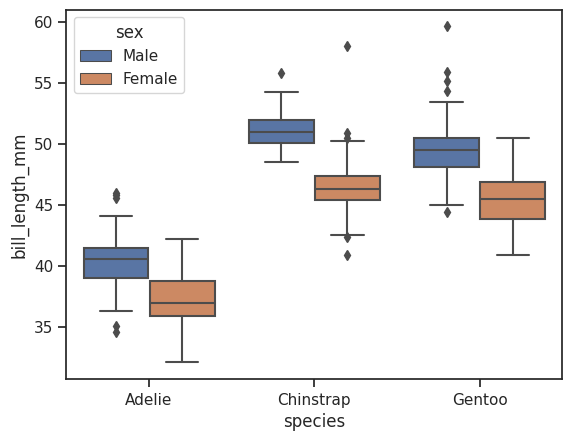

In [6]:
# Antes de preenchermos a coluna sex com valores provenientes do modelo,
# deve-se observar se vale a pena o intento. Para tanto, faz-se necessário
# realizar uma análise descritiva do processo, que no caso será se as características
# corpóreas são sginificativamente discrepantes.

sns.set_theme(style="ticks")

sns.boxplot(data=df, x='species',
            hue="sex", y='bill_length_mm')

<Axes: xlabel='bill_length_mm', ylabel='bill_depth_mm'>

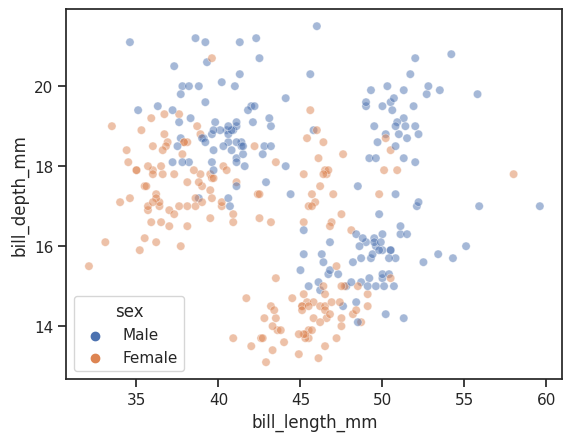

In [7]:
sns.scatterplot(x="bill_length_mm",
                y="bill_depth_mm",
                alpha=0.5,
                data=df,
                hue="sex")

A partir desses gráficos, parece que de fato as características corpóreas são significativas na distinção dos sexos. Desse modo, iremos preencher os dados faltantes por meio do modelo.

In [8]:
df = df[~ df['sex'].isna()]
df.shape

(333, 7)

In [9]:
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


In [10]:
# Separando em dois segmentos os dados, variável resposta e explicativa, bem
# segmentando em dados de treino e teste.

y = df.sex
X = pd.get_dummies(df.drop(columns=["sex"]), drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state=22)

X_train.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,species_Chinstrap,species_Gentoo,island_Dream,island_Torgersen
257,44.4,17.3,219.0,5250.0,0,1,0,0
125,40.6,19.0,199.0,4000.0,0,0,0,1
178,50.5,18.4,200.0,3400.0,1,0,1,0
25,35.3,18.9,187.0,3800.0,0,0,0,0
163,51.7,20.3,194.0,3775.0,1,0,1,0


In [11]:
# Criando a primeira árvore de decisão. Essa não apresenta em si
# já o número máximo de ramos ou de nós, os quais serão aferidos
# posteriormente, tendo em vista que estou utilizando a abordagem
# dos ccp_alphas.

clf0 = DecisionTreeClassifier(random_state=22)
path = clf0.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

##### Realiza a pós poda
Sobre a árvore acima, que é super complexa, vamos obter árvores derivadas e menos complexas seguindo o caminho indicado pelo custo de complexidade (o *ccp alpha*). Para cada árvore derivada, vamos avaliar a métrica de desempenho (no caso, a acurácia), e escolher a melhor árvore para fazer a imputação.

In [12]:
clfs0 = []
for ccp_alpha in ccp_alphas:
    clf0 = DecisionTreeClassifier(random_state=22, ccp_alpha=ccp_alpha).fit(X_train, y_train)
    clfs0.append(clf0)

clfs0

# As árvores que foram criadas.

[DecisionTreeClassifier(random_state=22),
 DecisionTreeClassifier(ccp_alpha=0.0032128514056224892, random_state=22),
 DecisionTreeClassifier(ccp_alpha=0.003398208217485326, random_state=22),
 DecisionTreeClassifier(ccp_alpha=0.0035140562248995983, random_state=22),
 DecisionTreeClassifier(ccp_alpha=0.003658676940037676, random_state=22),
 DecisionTreeClassifier(ccp_alpha=0.0039226674138414155, random_state=22),
 DecisionTreeClassifier(ccp_alpha=0.003955214798588286, random_state=22),
 DecisionTreeClassifier(ccp_alpha=0.004848036647870254, random_state=22),
 DecisionTreeClassifier(ccp_alpha=0.005466309683177152, random_state=22),
 DecisionTreeClassifier(ccp_alpha=0.006622302414165518, random_state=22),
 DecisionTreeClassifier(ccp_alpha=0.006884681583476765, random_state=22),
 DecisionTreeClassifier(ccp_alpha=0.011562910398118333, random_state=22),
 DecisionTreeClassifier(ccp_alpha=0.017738310037943357, random_state=22),
 DecisionTreeClassifier(ccp_alpha=0.020376131889614388, random_stat

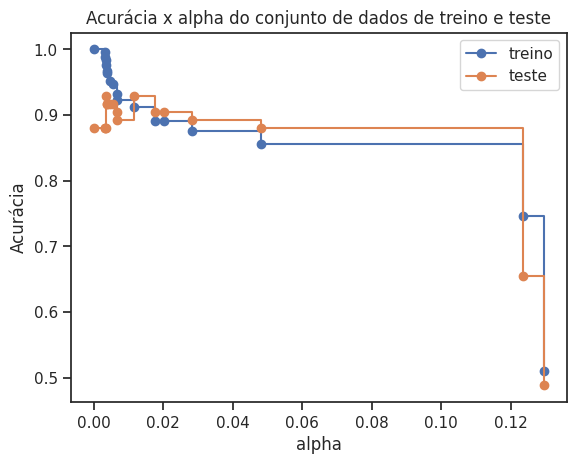

In [13]:
# Encontrando a melhor combinação de árvore com base em seu ccp_alpha:

train_scores = [clf0.score(X_train, y_train) for clf0 in clfs0]
test_scores  = [clf0.score(X_test, y_test)   for clf0 in clfs0]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Acurácia")
ax.set_title("Acurácia x alpha do conjunto de dados de treino e teste")
ax.plot(ccp_alphas, train_scores, marker='o', label="treino",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="teste",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [14]:
# Retornando um dataframe que me mostra o valor da acurácia por ccp_aplha utilizado.

pd.DataFrame({"alpha": ccp_alphas.tolist(),
              "test_scores": test_scores,
              "train_scores": train_scores})

# A partir das pontuações de teste e de treino, verifica-se que o melhor alpha
# para a criação da árvore é o 0.003659.

,alpha,test_scores,train_scores
0,0.000000,0.880952,1.000000
1,0.003213,0.880952,0.995984
2,0.003398,0.880952,0.987952
3,0.003514,0.880952,0.983936
4,0.003659,0.928571,0.975904
5,0.003923,0.916667,0.967871
6,0.003955,0.916667,0.963855
7,0.004848,0.916667,0.951807
8,0.005466,0.916667,0.947791
9,0.006622,0.904762,0.931727


Pronto. Abaixo tem uma "firula": Eu quero a melhor árvore, sim, mas se houverem empates, a que tenha a menor complexidade. Isso significa que eu quero pegar a maior métrica de desempenho no objeto ```test_scores```, mas se houver empates, queremos a primeira ocorrência desse máximo **da direita para a esquerda**.

Esse é um ótimo quebra cabeças de Python :) Abaixo temos um código bem pythonico que resolve isso.

In [15]:
# Outra forma de escolher a melhor árvore. Por meio dessa abordagem, o código
# escolhe aquela que apresenta menor complexidade, portanto a mais eficiente.

ind_melhor_arvore = len(test_scores) - test_scores[::-1].index(max(test_scores)) - 1
melhor_arvore = clfs0[ind_melhor_arvore]
melhor_arvore

DecisionTreeClassifier(ccp_alpha=0.011562910398118333, random_state=22)

In [16]:
# Seleciona as variáveis a serem substituídas
prever = pd.get_dummies(df.drop(columns = ['sex']), drop_first=True)
prever_sex = prever[df['sex'].notna()]

#faz a classificação conforme a árvore
inputação_sex = melhor_arvore.predict(prever_sex)
inputação_sex

array(['Male', 'Male', 'Female', 'Female', 'Male', 'Female', 'Male',
       'Female', 'Male', 'Male', 'Female', 'Female', 'Male', 'Female',
       'Male', 'Female', 'Female', 'Male', 'Male', 'Male', 'Male', 'Male',
       'Female', 'Female', 'Male', 'Female', 'Male', 'Female', 'Male',
       'Female', 'Male', 'Male', 'Female', 'Female', 'Male', 'Female',
       'Male', 'Female', 'Male', 'Female', 'Male', 'Male', 'Female',
       'Male', 'Female', 'Male', 'Female', 'Male', 'Female', 'Male',
       'Female', 'Male', 'Female', 'Male', 'Female', 'Male', 'Female',
       'Male', 'Female', 'Male', 'Female', 'Male', 'Female', 'Male',
       'Female', 'Male', 'Female', 'Male', 'Female', 'Male', 'Female',
       'Male', 'Female', 'Male', 'Female', 'Male', 'Male', 'Male',
       'Female', 'Male', 'Male', 'Female', 'Male', 'Female', 'Female',
       'Male', 'Female', 'Male', 'Female', 'Male', 'Female', 'Male',
       'Female', 'Male', 'Male', 'Male', 'Female', 'Male', 'Female',
       'Male', 'Ma

In [17]:
# Faz a substituição propriamente dita
df.loc[df['sex'].isna(), 'sex'] = inputação_sex

print(df.shape)
df.isna().sum()

(333, 7)


species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

### Classificação multinomial<a name="3"></a>

Pronto, agora sim vamos para o tema principal: construir um algoritmo que classifique a **espécie** do pinguim em uma das três que aparecem na base de dados. A mecânica aqui é MUITO parecida com a classificação binária, basta utilizarmos generalizações das funções de impureza que comportem mais de duas classes e pronto: podemos usar o mesmo algoritmo.

Vamos seguir aqui passos bem parecidos:
- Tratar *missings* (acabamos de fazer isso)
- Criar *dummies*
- Construir a árvore (e deixa-la "ser feliz")
- Realizar a pós-poda e obter a árvore "ótima"

In [18]:
X = pd.get_dummies(df.drop(columns = ['species', 'island']), drop_first=True)
y = df['species']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,
                                                    random_state = 22)

A árvore que será construída se dará por meio do método de pós-poda. A sua principal vantagem em comparação com o método da pré-poda se relaciona ao seus aspecto automatizado, no qual conseguimos executar por meio de um ciclo for uma série de árvores, que nos trará seus ccp_alphas relativos a cada pontuação no treino e teste. O ccp_alpha é um hiperparâmetro que compreende o ponto tanto de quantidade de nós presentes numa folha quanto o máximo de profundidade numa árvore.

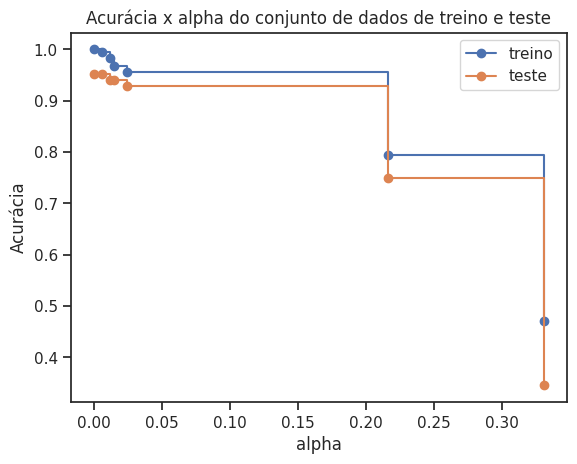

In [19]:
# Criando a árvore que realizará a pós-poda, encontrando para mim os
# respectivos ccp_alphas:

caminho = DecisionTreeClassifier(random_state=22).cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = caminho.ccp_alphas, path.impurities

# Armazenando numa lista todas as árvores geradas a partir dos ccp_alphas
# encontrados.

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=22, ccp_alpha=ccp_alpha).fit(X_train, y_train)
    clfs.append(clf)

# Criando uma lista que armazena os valores de treino e teste numa lista.

train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

# Criando um gráfico que me permite analisar visualmente o ponto
# de ótimo do ccp_alpha com base nas pontuações de treino e teste.

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Acurácia")
ax.set_title("Acurácia x alpha do conjunto de dados de treino e teste")
ax.plot(ccp_alphas, train_scores, marker='o', label="treino",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="teste",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [20]:
# Retornando um dataframe que me mostra o valor da acurácia por ccp_aplha utilizado.

pd.DataFrame({"alpha": ccp_alphas.tolist(),
              "test_scores": test_scores,
              "train_scores": train_scores})

# A partir das pontuações de teste e de treino, verifica-se que o melhor alpha
# para a criação da árvore é o 0.003659.

,alpha,test_scores,train_scores
0,0.000000,0.952381,1.000000
1,0.006024,0.952381,0.995984
2,0.011734,0.940476,0.983936
3,0.014726,0.940476,0.967871
4,0.024890,0.928571,0.955823
5,0.215739,0.750000,0.795181
6,0.330870,0.345238,0.469880


In [21]:
# Outra forma de escolher a melhor árvore. Por meio dessa abordagem, o código
# escolhe aquela que apresenta menor complexidade, portanto a mais eficiente.

ind_melhor_arvore = len(test_scores) - test_scores[::-1].index(max(test_scores)) - 1
melhor_arvore = clfs[ind_melhor_arvore]
melhor_arvore

DecisionTreeClassifier(ccp_alpha=0.006024096385542169, random_state=22)

**Avaliando a acurácia da árvore:**

In [22]:
from sklearn.metrics import accuracy_score

clf = melhor_arvore.fit(X_train, y_train)
y_predict = melhor_arvore.predict(X_test)

# Ela apresenta essa acurácia.

acuracia = round(accuracy_score(y_test, y_predict),2)
print(f"A árvore apresenta uma acurácia de {acuracia} %")

A árvore apresenta uma acurácia de 0.95 %


**Criando o DummyClassifier para comparar com a acurácia do modelo criado:**

In [33]:
from sklearn.dummy import DummyClassifier

In [35]:
# Segmentando os dados para treino e teste para a realização do
# modelo do DummyClassifier.

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=22)

# Crie um DummyClassifier
dummy_classifier = DummyClassifier()

# Treine o DummyClassifier
dummy_classifier.fit(X_train, y_train)

# Faça previsões com o DummyClassifier
dummy_predictions = dummy_classifier.predict(X_test)

# Avalie a acurácia do DummyClassifier
dummy_accuracy = accuracy_score(y_test, dummy_predictions)
print(f'Acurácia do DummyClassifier: {dummy_accuracy:.2f}')

# A partir do "Dummy" encontrado, podemos supor que o nosso modelo
# pode ser bom, tendo em vista que a sua acurácia foi muito acima
# do Dummy.

Acurácia do DummyClassifier: 0.35


In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

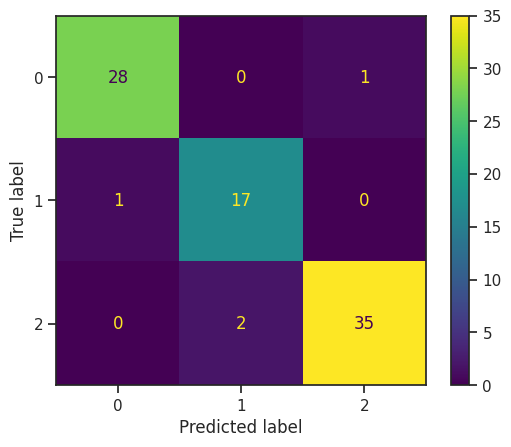

In [32]:
# Criando a matriz de correlação a partir da nova árvore gerada.

cm = confusion_matrix(y_test, y_predict)

display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot()

**Cross Validation:**

Refere-se ao ato de avaliar como o resultado do modelo pode ser generalizado para uma população mais ampla, ou seja, como o modelo se procede na prática.

Do mesmo modo, a sua realização se dá com a adição de uma outra etapa perante o treino e o teste, que é a validação.

A separação dos dados em conjuntos de treino, validação e teste é uma prática crucial em ciência de dados e aprendizado de máquina. Essa abordagem é fundamental por vários motivos:

1. **Avaliação de Desempenho:**
   - **Treino:** Os modelos aprendem com os dados de treino. Essa etapa é fundamental para que o modelo se ajuste aos padrões presentes nos dados.
   - **Validação:** Os dados de validação são usados para ajustar hiperparâmetros e escolher entre diferentes modelos. Isso ajuda a evitar o overfitting, onde o modelo se ajusta demais aos dados de treino e não generaliza bem para novos dados.
   - **Teste:** Os dados de teste são reservados para avaliar o desempenho final do modelo. Este conjunto é crucial para obter uma estimativa imparcial do quão bem o modelo generaliza para dados não vistos.

2. **Prevenção de Overfitting:**
   - Se você usar os mesmos dados para treino e validação, há um risco maior de overfitting, pois o modelo pode acabar se ajustando muito bem a esses dados específicos, mas falhar ao generalizar para novos dados.

3. **Estimativa Realista de Desempenho:**
   - A avaliação do modelo em dados de teste fornece uma estimativa mais realista do desempenho do modelo em condições do mundo real, pois esses dados não foram usados durante o treinamento ou validação.

4. **Ajuste de Hiperparâmetros:**
   - O conjunto de validação é usado para ajustar os hiperparâmetros do modelo (por exemplo, taxa de aprendizado, número de camadas, número de neurônios em cada camada) sem impactar a avaliação final do modelo.

5. **Reprodutibilidade:**
   - Ao dividir os dados dessa maneira, você pode ter um processo mais controlado e reprodutível. Outros cientistas de dados ou pesquisadores podem replicar seus experimentos usando os mesmos conjuntos de treino, validação e teste.

Em resumo, a separação dos dados em treino, validação e teste é uma prática essencial para garantir que o modelo seja treinado e avaliado de maneira robusta, evitando armadilhas como overfitting e fornecendo uma estimativa realista de seu desempenho em dados não vistos.

In [36]:
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


In [37]:
df.isna().sum()

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

Separando os datos em treino (60%), validação (20%) e teste (20%).

In [38]:
# Dropando as colunas island e species para X, uma vez que ele
# compreende, precisa apenas das variáveis explicativas salutares.

X = pd.get_dummies(df.drop(columns=['island','species']), drop_first=True)
y = df.species

X_, X_test, y_, y_test = train_test_split(X, y, test_size=.20, random_state=22)
X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=.25, random_state=15)

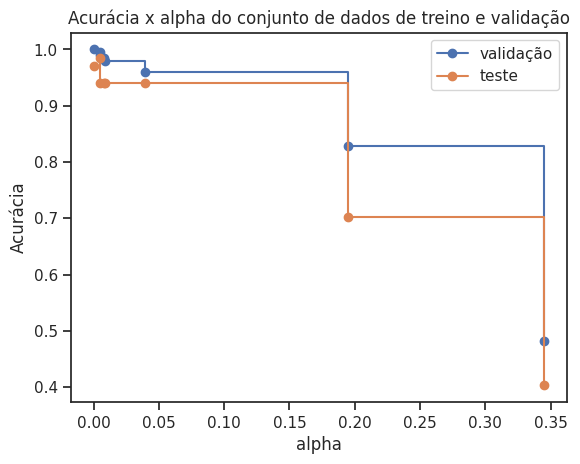

In [39]:
# Calculando o hiperparâmetro ccp_alpha, que em si define os nós e a profundidade
# da árvore.

caminho = DecisionTreeClassifier(random_state=2360873).cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = caminho.ccp_alphas, caminho.impurities

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=2360873, ccp_alpha=ccp_alpha).fit(X_train, y_train)
    clfs.append(clf)

train_scores = [clf.score(X_train, y_train) for clf in clfs]
valid_scores = [clf.score(X_valid, y_valid) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Acurácia")
ax.set_title("Acurácia x alpha do conjunto de dados de treino e validação")
ax.plot(ccp_alphas, train_scores, marker='o', label="validação",
        drawstyle="steps-post")
ax.plot(ccp_alphas, valid_scores, marker='o', label="teste",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [46]:
ind_melhor_arvore = len(valid_scores) - valid_scores[::-1].index(max(valid_scores)) - 1
melhor_arvore = clfs[ind_melhor_arvore]

print(f'Acurácia da melhor árvore na base de validação: {valid_scores[ind_melhor_arvore]*100:.2f} %')

melhor_arvore

Acurácia da melhor árvore na base de validação: 98.51 %


DecisionTreeClassifier(ccp_alpha=0.004851845434066883, random_state=2360873)

In [45]:
# Mensurando a acurácia da melhor árvore:

acuracia_teste = melhor_arvore.score(X_test, y_test)
print(f"A acurácia da melhor árvore é de {round(acuracia_teste, 2)*100} %")

A acurácia da melhor árvore é de 96.0 %


Note que a acurácia da validação é maior do que a do teste, segundo o professor isso é normal.

# Tipos de cross validation:

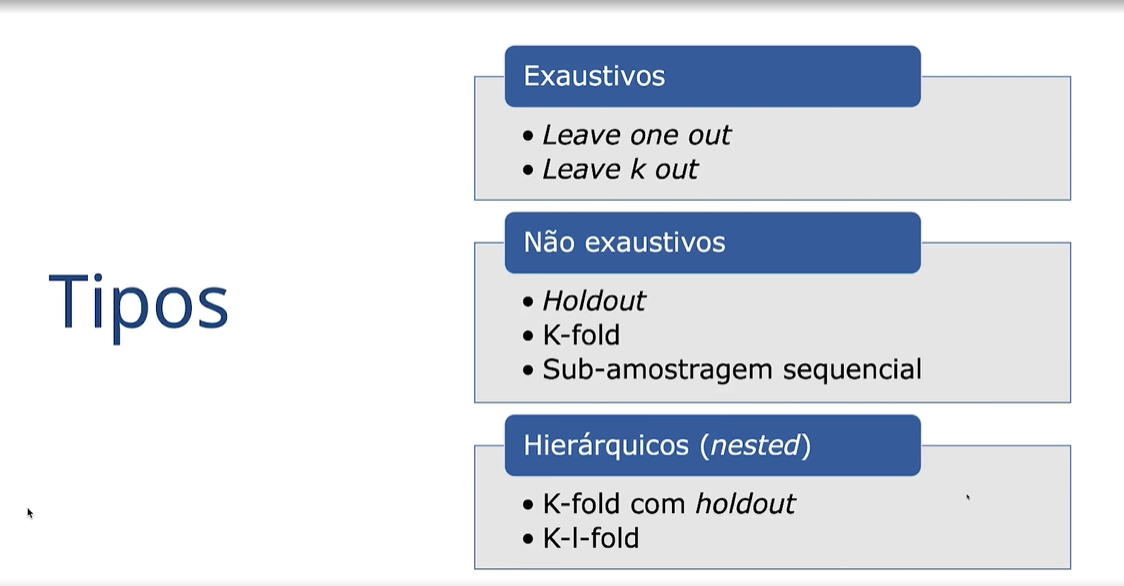

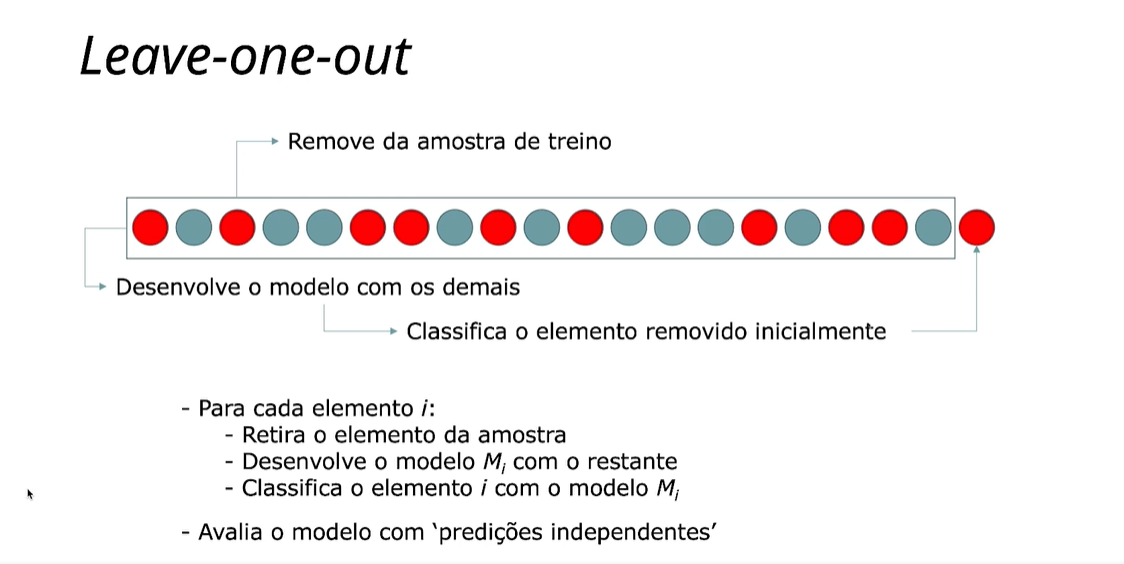

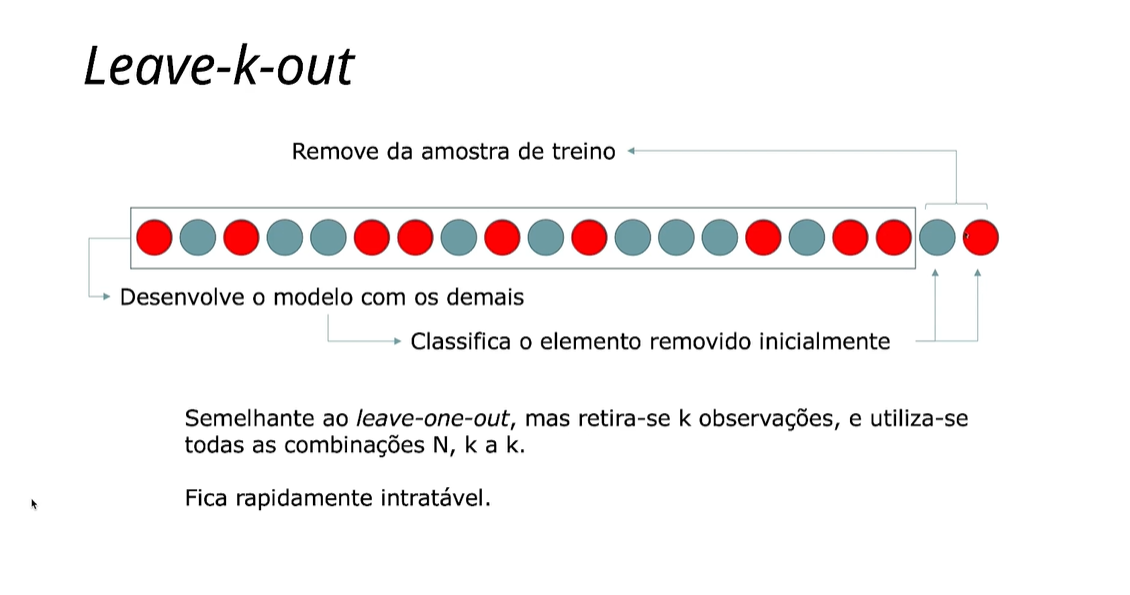

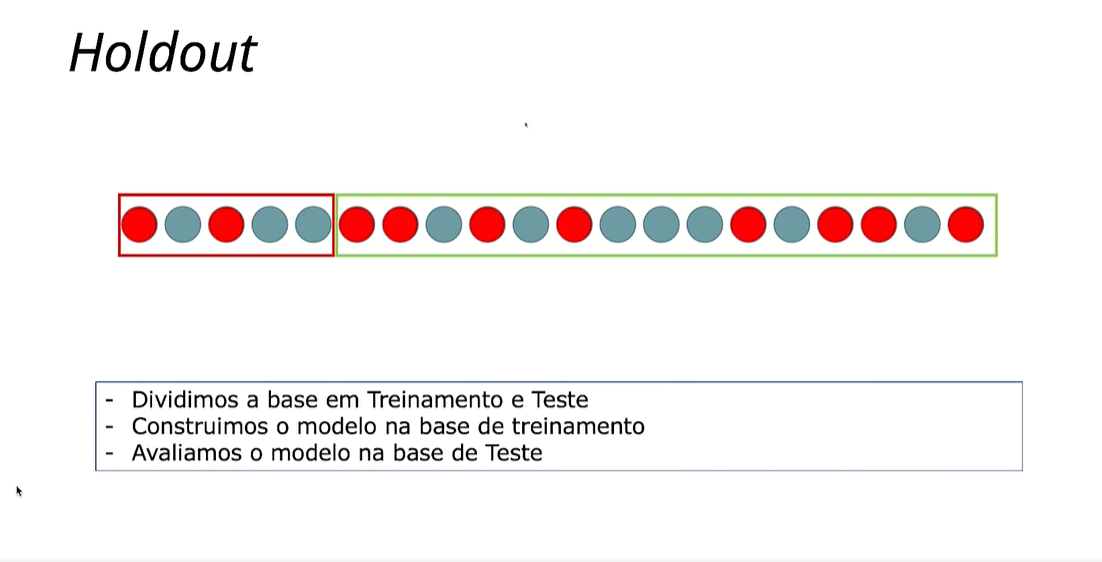

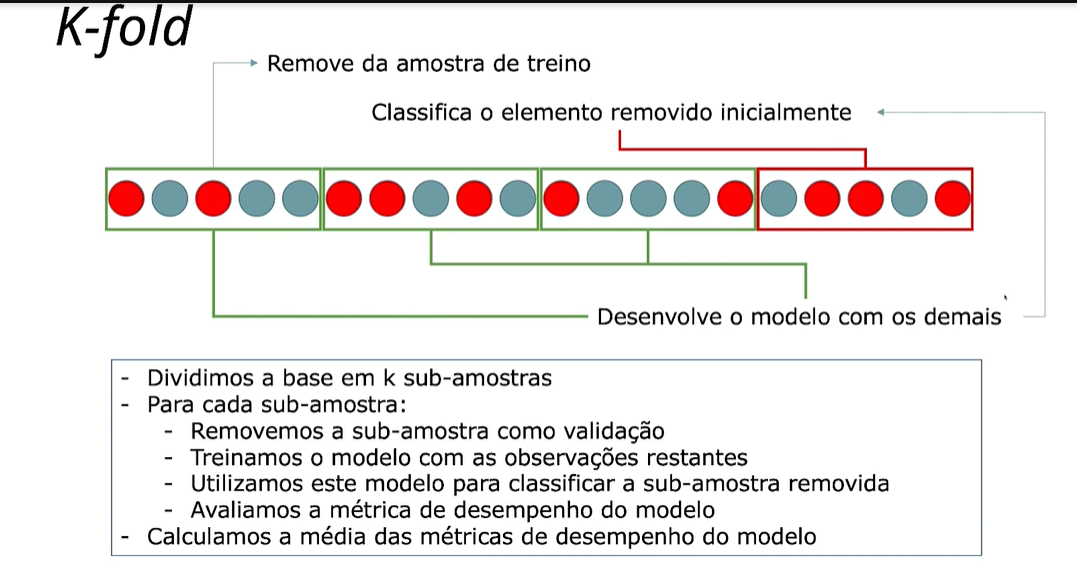

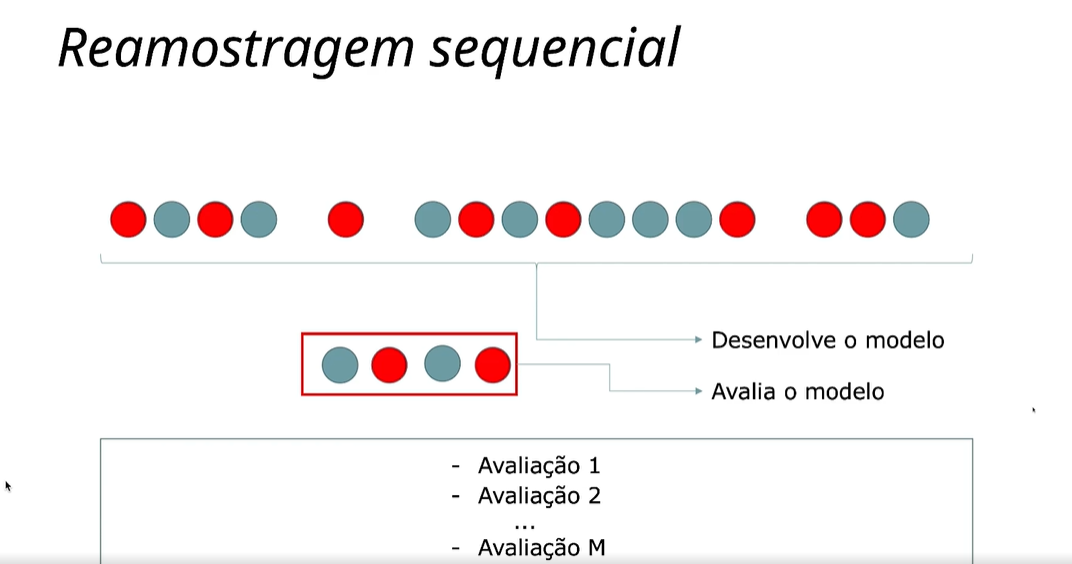

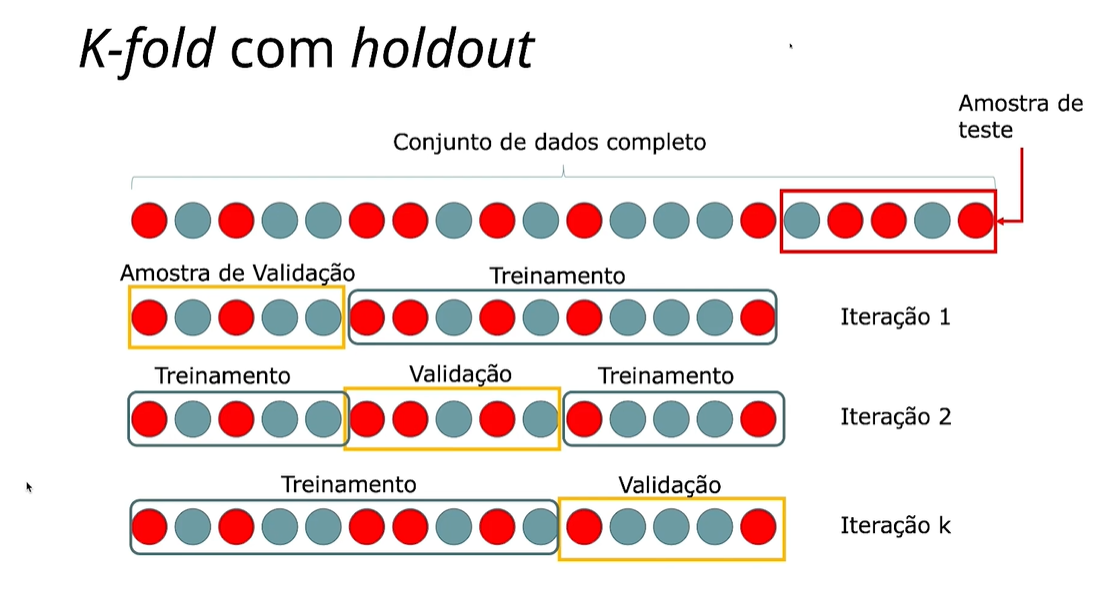

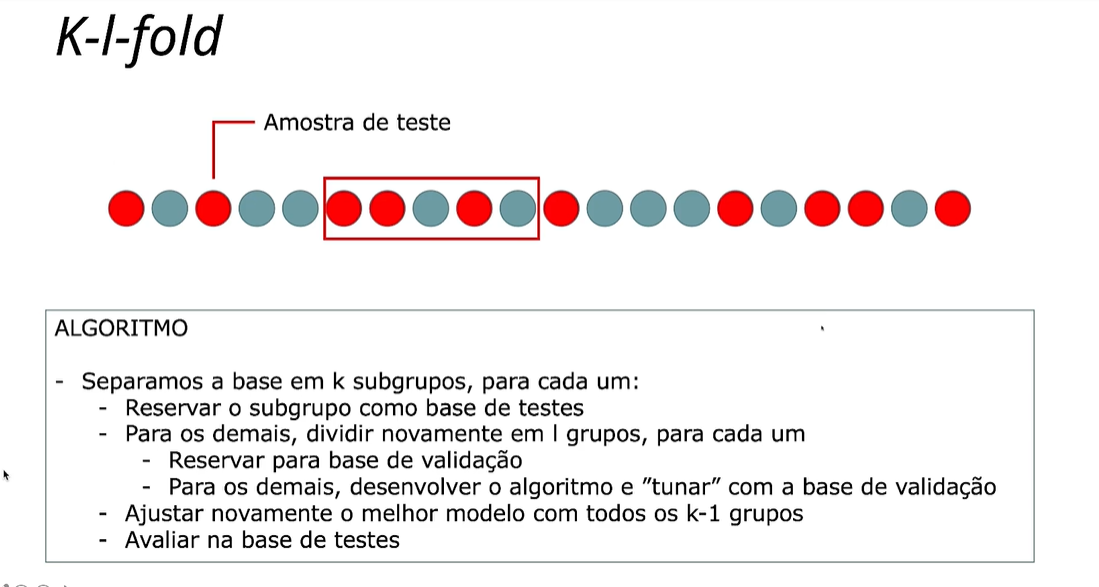

Dentre os melhores tipos de validação cruzada está os hierárquicos, pois eles realizam desde a segmentação do conjunto de dados em treino, validação e teste, selecionando a partir do treinamento e validação o melhor modelo que apresenta a melhor acurácia, com base nos hiperparâmetros analisados.

Para realizarmos a validação cruzada hierárquica separa-se o conjunto de dados em treino e teste, cria-se o modelo para encontrar, por meio do método de pós-poda, os hiperparâmetros da árvore, que no caso é o ccp_alpha, passando depois na função GridSearchCV(), que realiza o processo de K-fold junto do holdout (a porção teste separada).

O GridSearchCV é construido da seguinte forma:

```
GridSearchCV(
    estimator,
    param_grid,
    scoring=None,
    cv=None
)
```
- **estimator**: aqui indicamos qual modelo vamos utilizar.
- **param_grid**: esse vai ser um dicionário, em que a chave é o nome dos hiperparâmetros e o valor vai ser uma lista com as possibilidades que queremos testar.
- **scoring**: vai ser a métrica de avaliação de performance do nosso modelo. No caso vamos usar a acurácia.
- **CV**: Este parâmetro, se especificado como um inteiro, é o *k* do *k-fold*.

In [48]:
# Segmentando o conjunto de dados em treino e teste:

pg1 = df.copy()

X = pd.get_dummies(pg1.drop(columns=['island','species']), drop_first=True)
y = pg1.species

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=2360873)

In [49]:
# Criando a árvore que nos trará os respectivos ccp_alphas:

clf = DecisionTreeClassifier(random_state=2360873)
caminho = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = caminho.ccp_alphas, caminho.impurities

In [51]:
# Garantindo que os ccp_alphas são únicos e positivos
ccp_alphas = np.unique(ccp_alphas[ccp_alphas>=0])
ccp_alphas

array([0.        , 0.00367941, 0.00372459, 0.0037594 , 0.00601504,
       0.0070522 , 0.00725939, 0.00994987, 0.03001563, 0.21416327,
       0.33686517])

In [52]:
from sklearn.model_selection import GridSearchCV

In [53]:
# Criando o modelo da árvore:
clf = DecisionTreeClassifier(random_state=2360873)

# Criando o dicionário que irei passar no grid:
grid_parametros = {'ccp_alpha':ccp_alphas}

# cv -> quantidade de subcamadas que o K-Fold realizará.
# verbose -> permite ver no output o tempo de execução de cada processo.

grid = GridSearchCV(estimator = clf, param_grid=grid_parametros,cv=15, verbose=100)
grid.fit(X_train, y_train)
grid

Fitting 15 folds for each of 11 candidates, totalling 165 fits
[CV 1/15; 1/11] START ccp_alpha=0.0.............................................
[CV 1/15; 1/11] END ..............ccp_alpha=0.0;, score=0.944 total time=   0.0s
[CV 2/15; 1/11] START ccp_alpha=0.0.............................................
[CV 2/15; 1/11] END ..............ccp_alpha=0.0;, score=1.000 total time=   0.0s
[CV 3/15; 1/11] START ccp_alpha=0.0.............................................
[CV 3/15; 1/11] END ..............ccp_alpha=0.0;, score=0.944 total time=   0.0s
[CV 4/15; 1/11] START ccp_alpha=0.0.............................................
[CV 4/15; 1/11] END ..............ccp_alpha=0.0;, score=0.944 total time=   0.0s
[CV 5/15; 1/11] START ccp_alpha=0.0.............................................
[CV 5/15; 1/11] END ..............ccp_alpha=0.0;, score=0.944 total time=   0.0s
[CV 6/15; 1/11] START ccp_alpha=0.0.............................................
[CV 6/15; 1/11] END ..............ccp_alpha=0.

GridSearchCV(cv=15, estimator=DecisionTreeClassifier(random_state=2360873),
             param_grid={'ccp_alpha': array([0.        , 0.00367941, 0.00372459, 0.0037594 , 0.00601504,
       0.0070522 , 0.00725939, 0.00994987, 0.03001563, 0.21416327,
       0.33686517])},
             verbose=100)

In [54]:
# Mostrando os resultados do GridSearchCV em um dataframe, para melhorar a
# visualização.

resultados = pd.DataFrame(grid.cv_results_)
resultados.head()

# A vantagem dessa tabela é de que ela me traz o rank do melhor modelo,
# através da coluna rank.

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score
0,0.005998,0.002747,0.003465,0.002872,0.0,{'ccp_alpha': 0.0},0.944444,1.0,0.944444,0.944444,...,0.944444,1.000000,0.944444,1.0,1.0,1.000000,0.882353,0.969935,0.035403,1
1,0.005240,0.001160,0.002613,0.000729,0.003679,{'ccp_alpha': 0.0036794112941929322},0.944444,1.0,0.944444,0.944444,...,0.944444,1.000000,0.944444,1.0,1.0,1.000000,0.882353,0.969935,0.035403,1
2,0.005705,0.000541,0.003630,0.000508,0.003725,{'ccp_alpha': 0.003724589250905047},0.944444,1.0,0.944444,0.944444,...,0.944444,1.000000,0.944444,1.0,1.0,1.000000,0.882353,0.969935,0.035403,1
3,0.006238,0.000471,0.003647,0.000229,0.003759,{'ccp_alpha': 0.0037593984962406013},0.944444,1.0,0.944444,0.944444,...,0.944444,1.000000,0.944444,1.0,1.0,1.000000,0.882353,0.969935,0.035403,1
4,0.007838,0.002618,0.004310,0.001826,0.006015,{'ccp_alpha': 0.006015037593984961},0.944444,1.0,0.944444,0.888889,...,0.944444,0.944444,0.944444,1.0,1.0,0.941176,0.941176,0.962527,0.033388,8


In [56]:
# Um método rápido de saber qual é o melhor modelo.
grid.best_index_

0

In [58]:
# A partir da validação cruzada, encontramos o melhor hiperparâmetro e o
# passamos na construção do modelo que realizará a etapa do teste, como forma
# de mensurarmos a sua acurácia.

melhor_ccp = 0.0

clf = DecisionTreeClassifier(random_state=2360873, ccp_alpha=melhor_ccp).fit(X_train, y_train)
print(f"A acurácia do melhor modelo é de {round(clf.score(X_test, y_test), 2)*100} %")

A acurácia do melhor modelo é de 96.0 %
